step 1- Load libraries

In [13]:
# ===== Imports, seeds, and GPU setup =====

# Standard libraries
import os, random                              # OS utilities and reproducibility helpers
import numpy as np                             # Numerical arrays

# TensorFlow / Keras
import tensorflow as tf                        # Main DL framework

# Keras layers & utilities
from tensorflow.keras.layers import (Input, SeparableConv2D, DepthwiseConv2D, BatchNormalization,
                                     Activation, AveragePooling2D, Dropout, Dense, Add, Lambda,
                                     GlobalAveragePooling2D, GlobalAveragePooling1D,
                                     MultiHeadAttention, Reshape, LayerNormalization, Conv2D)
from tensorflow.keras.models import Model      # Functional model API
from tensorflow.keras.optimizers import Adam   # Optimizer
from tensorflow.keras.losses import BinaryCrossentropy  # Binary classification loss
from tensorflow.keras.metrics import Accuracy  # Accuracy metric
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Training callbacks
from tensorflow.keras import backend as K      # Keras backend for static shape queries

# Scikit-learn utilities
from sklearn.model_selection import StratifiedKFold                  # Stratified 5-fold CV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  # Metrics

# Plotting
import matplotlib.pyplot as plt               # For charts

# Reproducibility
SEED = 42                                     # Fixed seed
np.random.seed(SEED)                          # Seed NumPy
tf.random.set_seed(SEED)                      # Seed TensorFlow
random.seed(SEED)                             # Seed Python

# Optional: make TensorFlow more gentle with GPU memory
gpus = tf.config.list_physical_devices('GPU') # Detect GPUs
print("TensorFlow:", tf.__version__)          # Show TF version
print("GPUs:", gpus)                          # Show detected GPUs
if gpus:                                      # If GPU(s) are present
    for g in gpus:                            # Iterate each GPU
        try:
            tf.config.experimental.set_memory_growth(g, True)  # Enable memory growth
        except Exception as e:
            print("GPU memory growth not set:", e)             # Warn if not possible


TensorFlow: 2.20.0
GPUs: []


Step 2- Load arrays

In [14]:
# ===== Step 1: Load the arrays in the given path (no normalization) =====

# Exact Windows paths you provided (raw strings to avoid backslash escapes)
eeg_path    = r"C:\Self Learning\Research Papers\UOW Research Papers\eSport Players with EEG Data\EEG Data\final eeg data\final_eeg_pp.npy"
labels_path = r"C:\Self Learning\Research Papers\UOW Research Papers\eSport Players with EEG Data\EEG Data\final eeg data\final_eeg_labels.npy"

print("Loading EEG data...")                 # Status print
X = np.load(eeg_path)                        # Load EEG data, expected shape (N, 14, 200)
y = np.load(labels_path)                     # Load labels, expected shape (N,) or (N,1)
print("Loaded.")                             # Confirm loaded

print("Raw X shape:", X.shape, "| dtype:", X.dtype)  # Inspect EEG tensor
print("Raw y shape:", y.shape, "| dtype:", y.dtype)  # Inspect labels

y = np.squeeze(y).astype(int)                # Ensure labels are 1D int array
print("y squeezed shape:", y.shape, "| unique labels:", np.unique(y))  # Show label distribution

# Sanity checks on shapes and labels
assert X.ndim == 3, f"Expected X to be (N,14,200). Got {X.shape}"      # Check rank
assert X.shape[1] == 14 and X.shape[2] == 200, "Expected 14 electrodes and 200 samples per segment."  # Check dims
assert set(np.unique(y)).issubset({0,1}), "Labels must be {0,1}."      # Binary check

# Add channel dimension for Keras Conv2D: (N, 14, 200, 1)
X = X[..., np.newaxis]                         # Append channel dim
print("X after adding channel dim:", X.shape)  # Verify final input shape


Loading EEG data...
Loaded.
Raw X shape: (4770, 14, 200) | dtype: float64
Raw y shape: (4770,) | dtype: int64
y squeezed shape: (4770,) | unique labels: [0 1]
X after adding channel dim: (4770, 14, 200, 1)


Step 3 : Prepare 5-fold cross-validation

In [15]:
# ===== Step 2: Prepare the data to perform 5-fold cross validation =====

N_SPLITS = 5                                   # Number of CV folds
skf = StratifiedKFold(n_splits=N_SPLITS,       # Stratified (preserves class ratios)
                      shuffle=True,            # Shuffle before splitting
                      random_state=SEED)       # Reproducible splits

print(f"Prepared StratifiedKFold with {N_SPLITS} splits.")  # Status
print("Total samples:", X.shape[0])                         # Dataset size


Prepared StratifiedKFold with 5 splits.
Total samples: 4770


Step 4 : Define AFNet

In [16]:
# ===== Step 3: Define AFNet (your code, only shape edits + Keras-safe ops) =====

def SpatialAttention(x):
    """Spatial attention to weight electrodes; uses Keras Reshape/Multiply (no raw tf ops on KerasTensors)."""
    num_electrodes = K.int_shape(x)[1]                        # Static electrode count (14)
    attn = GlobalAveragePooling2D()(x)                        # Global pool -> (batch, channels)
    attn = Dense(64, activation='relu')(attn)                 # Dense to learn attention features
    attn = Dense(num_electrodes, activation='sigmoid')(attn)  # One weight per electrode
    attn = Reshape((num_electrodes, 1, 1))(attn)              # Reshape for broadcast across time & channels
    x = tf.keras.layers.Multiply()([x, attn])                 # Apply attention weights
    return x                                                  # Return attended feature maps

def TransformerBlock(x, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1):
    """Transformer encoder block: MHA + FFN with residuals and layer norms."""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)  # Self-attention
    attn_output = Dropout(dropout_rate)(attn_output)                               # Dropout
    x = Add()([x, attn_output])                                                   # Residual
    x = LayerNormalization()(x)                                                   # LayerNorm

    ff = Dense(ff_dim, activation='relu')(x)                                      # Feed-forward (expand)
    ff = Dropout(dropout_rate)(ff)                                                # Dropout
    ff = Dense(x.shape[-1])(ff)                                                   # Project back
    x = Add()([x, ff])                                                            # Residual
    x = LayerNormalization()(x)                                                   # LayerNorm
    return x                                                                      # Return block output

def EEGNet_SpatialTransformer(input_shape=(14, 200, 1), dropout_rate=0.5, num_heads=4, ff_dim=128):
    """AFNet adapted for (14,200,1); keeps your structure, minimal shape handling for residual add."""
    print("Building model with input_shape:", input_shape)                         # Trace

    inputs = Input(shape=input_shape)                                              # Input tensor

    # Depthwise Separable Convolution (temporal)
    x = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)       # First sep conv
    x = BatchNormalization()(x)                                                    # BN
    x = Activation('relu')(x)                                                      # ReLU
    print("After sepconv1:", x.shape)                                              # Shape trace

    # Spatial Attention
    x = SpatialAttention(x)                                                        # Attention over electrodes
    print("After SpatialAttention:", x.shape)                                      # Shape trace

    # Depthwise Spatial Convolution across electrodes (change 61->14)
    x = DepthwiseConv2D((14, 1), use_bias=False, depth_multiplier=2, padding='valid')(x)  # Collapse electrode dim
    x = BatchNormalization()(x)                                                    # BN
    x = Activation('relu')(x)                                                      # ReLU
    print("After depthwise spatial:", x.shape)                                     # Shape trace (electrode dim -> 1)

    # Residual branch from inputs via the same first sepconv path (to get 32 channels & same HxW)
    res = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)      # Residual features (14x200x32)
    res = BatchNormalization()(res)                                                # BN
    res = Activation('relu')(res)                                                  # ReLU
    print("Residual branch shape:", res.shape)                                     # Shape trace

    # Project x back to 32 channels so we can add with residual
    x = Conv2D(32, (1,1), padding='same', use_bias=False)(x)                       # 1x1 to 32 channels
    x = BatchNormalization()(x)                                                    # BN
    x = Activation('relu')(x)                                                      # ReLU
    print("After 1x1 proj to 32:", x.shape)                                        # Shape trace (1x200x32)

    # Tile the electrode axis from 1 -> 14 to match residual spatial dims for Add()
    x = Lambda(lambda t: tf.repeat(t, repeats=input_shape[0], axis=1))(x)          # Repeat along axis=1
    print("After tiling to electrodes=14:", x.shape)                                # Shape trace (14x200x32)

    # Add residual and continue
    x = Add()([x, res])                                                            # Residual add
    x = BatchNormalization()(x)                                                    # BN
    print("After residual add:", x.shape)                                          # Shape trace

    # First Average Pooling (temporal downsampling: 200 -> 50)
    x = AveragePooling2D((1, 4))(x)                                                # Pool time axis
    x = Dropout(dropout_rate)(x)                                                   # Dropout
    print("After avgpool1:", x.shape)                                              # Shape trace

    # Second separable conv block
    x = SeparableConv2D(64, (1, 3), padding='same', use_bias=False)(x)             # More features
    x = BatchNormalization()(x)                                                    # BN
    x = Activation('relu')(x)                                                      # ReLU
    print("After sepconv2:", x.shape)                                              # Shape trace

    # Second Average Pooling (temporal downsampling: ~50 -> ~12/13)
    x = AveragePooling2D((1, 4))(x)                                                # Pool time again
    x = Dropout(dropout_rate)(x)                                                   # Dropout
    print("After avgpool2:", x.shape)                                              # Shape trace

    # Transformer over electrodes (tokens = 14, features = T' * 64)
    x_shape = K.int_shape(x)                                                       # Static shape
    seq_len = x_shape[1]                                                           # Electrode tokens (14)
    feat_dim = x_shape[2] * x_shape[3]                                             # Feature dim per token
    x = Reshape((seq_len, feat_dim))(x)                                            # (batch, 14, T'*64)
    print("Before Transformer, reshaped to:", x.shape)                              # Trace shape

    x = TransformerBlock(x, num_heads=num_heads, key_dim=64, ff_dim=ff_dim, dropout_rate=0.1)  # Transformer

    # Classifier head
    x = GlobalAveragePooling1D()(x)                                                # Pool across tokens
    x = BatchNormalization()(x)                                                    # BN
    print("After GAP1D:", x.shape)                                                 # Shape trace

    x = Dense(128, activation='relu')(x)                                           # Dense layer
    x = BatchNormalization()(x)                                                    # BN
    x = Dropout(dropout_rate)(x)                                                   # Dropout
    outputs = Dense(1, activation='sigmoid')(x)                                    # Sigmoid for binary classification

    model = Model(inputs, outputs)                                                 # Build model
    return model                                                                   # Return uncompiled model


In [17]:
# ===== Helper: compile model and set up callbacks (Option A: save best .h5 per fold) =====

def compile_model():
    """Create and compile a fresh AFNet model instance."""
    model = EEGNet_SpatialTransformer(input_shape=(14, 200, 1))             # Build with correct input shape
    model.compile(optimizer=Adam(learning_rate=1e-3),                       # Adam optimizer (lr=1e-3)
                  loss=BinaryCrossentropy(),                                # Binary cross-entropy loss
                  metrics=[Accuracy()])                                     # Track Accuracy metric
    print(model.summary(line_length=120))                                   # Print model summary
    return model                                                            # Return compiled model

def make_callbacks(fold_idx):
    """Construct callbacks for a given fold: EarlyStopping + ReduceLROnPlateau + ModelCheckpoint(.h5)."""
    print(f"Setting up callbacks for fold {fold_idx}...")                   # Status print

    es = EarlyStopping(                                                     # Early stopping
        monitor='val_loss',                                                 # Monitor validation loss
        patience=15,                                                         # Wait 8 epochs without improvement
        restore_best_weights=True,                                          # Restore best weights
        verbose=1                                                           # Verbose messages
    )

    rlrop = ReduceLROnPlateau(                                              # Reduce LR on plateau
        monitor='val_loss',                                                 # Monitor validation loss
        factor=0.5,                                                         # Halve the LR
        patience=4,                                                         # After 4 stagnant epochs
        min_lr=1e-6,                                                        # Do not go below 1e-6
        verbose=1                                                           # Verbose messages
    )

    ckpt_path = f"best_fold_{fold_idx}.h5"                                  # Save best model as .h5 (HDF5)
    ckpt = ModelCheckpoint(                                                 # Checkpoint callback
        filepath=ckpt_path,                                                 # Output file path
        monitor='val_loss',                                                 # Select best by val_loss
        save_best_only=True,                                                # Only save when improved
        verbose=1                                                           # Verbose messages
        # Note: .h5 requires h5py installed; if missing, run: pip install h5py
    )

    return [es, rlrop, ckpt]                                                # Return callback list


In [18]:
# ===== Step 3 (training): 5-fold CV with per-fold confusion matrix + metrics =====

EPOCHS = 200                                                                   # Upper bound; EarlyStopping will cut earlier
BATCH_SIZE = 32                                                                # Batch size

per_fold_metrics = []                                                          # List to store per-fold metric dicts
histories = []                                                                 # Store Keras history dicts per fold

fold = 0                                                                       # Initialize fold counter
for train_idx, val_idx in skf.split(X, y):                                     # Iterate stratified folds
    fold += 1                                                                  # Increment fold number

    print("\n" + "="*90)                                                       # Visual separator
    print(f"Fold {fold} — Train/Val split")                                    # Announce fold
    print("Train idx:", train_idx.shape, "Val idx:", val_idx.shape)            # Show split sizes

    X_train, X_val = X[train_idx], X[val_idx]                                  # Slice EEG training/val data
    y_train, y_val = y[train_idx], y[val_idx]                                  # Slice labels training/val

    print("X_train:", X_train.shape, "| y_train:", y_train.shape)              # Print shapes
    print("X_val  :", X_val.shape,   "| y_val  :", y_val.shape)                # Print shapes

    model = compile_model()                                                    # Build + compile model
    callbacks = make_callbacks(fold)                                           # Create callbacks for this fold

    print("Training with EarlyStopping...")                                    # Status
    history = model.fit(                                                       # Fit model
        X_train, y_train,                                                      # Train data
        validation_data=(X_val, y_val),                                        # Validation data
        epochs=EPOCHS,                                                         # Max epochs
        batch_size=BATCH_SIZE,                                                 # Batch size
        callbacks=callbacks,                                                   # Callbacks list
        verbose=2                                                              # Per-epoch logs
    )

    histories.append(history.history)                                          # Store training history dict

    print("Predicting on validation fold...")                                  # Status
    y_prob = model.predict(X_val, batch_size=BATCH_SIZE).ravel()               # Predict probabilities
    y_pred = (y_prob >= 0.5).astype(int)                                       # Threshold at 0.5 to get classes

    # ----- Confusion Matrix & Per-fold Metrics -----
    cm = confusion_matrix(y_val, y_pred, labels=[0, 1])                        # Confusion matrix with label order [0,1]
    tn, fp, fn, tp = cm.ravel()                                                # Unpack counts

    print("\nFold", fold, "Confusion Matrix (rows=true, cols=pred) [0=Amateur, 1=Professional]:")
    print(cm)                                                                  # Print matrix
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")                               # Print counts

    acc  = accuracy_score(y_val, y_pred)                                       # Accuracy
    prec = precision_score(y_val, y_pred, pos_label=1, zero_division=0)        # Precision (class 1)
    sens = recall_score(y_val, y_pred,    pos_label=1, zero_division=0)        # Sensitivity/Recall (class 1)
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0                            # Specificity (class 0)
    f1   = f1_score(y_val, y_pred, pos_label=1, zero_division=0)               # F1-score (class 1)

    print("\nFold", fold, "Metrics (threshold=0.5):")                          # Header
    print(f"Accuracy    : {acc:.4f}")                                          # Accuracy
    print(f"Precision   : {prec:.4f}  (class 1: Professional)")                # Precision
    print(f"Sensitivity : {sens:.4f}     (Recall for class 1)")                # Sensitivity/Recall
    print(f"Specificity : {spec:.4f} (for class 0: Amateur)")                  # Specificity
    print(f"F1-score    : {f1:.4f}")                                           # F1

    per_fold_metrics.append({                                                  # Save per-fold metrics
        "fold": fold, "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "accuracy": float(acc), "precision": float(prec),
        "sensitivity": float(sens), "specificity": float(spec), "f1": float(f1)
    })

# ----- Per-fold summary printout -----
print("\n=== Per-Fold Metrics Summary ===")                                     # Header
for m in per_fold_metrics:                                                      # Iterate per-fold metrics
    print(f"Fold {m['fold']}: "
          f"Acc={m['accuracy']:.4f}, "
          f"Prec={m['precision']:.4f}, "
          f"Sens={m['sensitivity']:.4f}, "
          f"Spec={m['specificity']:.4f}, "
          f"F1={m['f1']:.4f} | "
          f"TN={m['tn']} FP={m['fp']} FN={m['fn']} TP={m['tp']}")               # Pretty per-fold line

# ----- Optional overall mean ± std across folds -----
accs  = [m["accuracy"]    for m in per_fold_metrics]                            # Collect accuracies
precs = [m["precision"]   for m in per_fold_metrics]                            # Collect precisions
sens  = [m["sensitivity"] for m in per_fold_metrics]                            # Collect sensitivities
specs = [m["specificity"] for m in per_fold_metrics]                            # Collect specificities
f1s   = [m["f1"]          for m in per_fold_metrics]                            # Collect F1 scores

print("\n=== Mean ± Std over 5 folds ===")                                      # Header
print(f"Accuracy    : {np.mean(accs):.4f} ± {np.std(accs):.4f}")                # Mean±Std accuracy
print(f"Precision   : {np.mean(precs):.4f} ± {np.std(precs):.4f}")              # Mean±Std precision
print(f"Sensitivity : {np.mean(sens):.4f} ± {np.std(sens):.4f}")                # Mean±Std sensitivity
print(f"Specificity : {np.mean(specs):.4f} ± {np.std(specs):.4f}")              # Mean±Std specificity
print(f"F1-score    : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")                  # Mean±Std F1



Fold 1 — Train/Val split
Train idx: (3816,) Val idx: (954,)
X_train: (3816, 14, 200, 1) | y_train: (3816,)
X_val  : (954, 14, 200, 1) | y_val  : (954,)
Building model with input_shape: (14, 200, 1)
After sepconv1: (None, 14, 200, 32)
After SpatialAttention: (None, 14, 200, 32)
After depthwise spatial: (None, 1, 200, 64)
Residual branch shape: (None, 14, 200, 32)
After 1x1 proj to 32: (None, 1, 200, 32)
After tiling to electrodes=14: (None, 14, 200, 32)
After residual add: (None, 14, 200, 32)
After avgpool1: (None, 14, 50, 32)
After sepconv2: (None, 14, 50, 64)
After avgpool2: (None, 14, 12, 64)
Before Transformer, reshaped to: (None, 14, 768)
After GAP1D: (None, 768)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_6 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_18               │ (None, 14, 200, 32)          │                37 │ input_layer_6[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_48            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_18[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_30 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_48[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_6        │ (None, 32)                   │                 0 │ activation_30[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_36 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_6
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_37 (Dense)                  │ (None, 14)                   │               910 │ dense_36[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_12 (Reshape)              │ (None, 14, 1, 1)             │                 0 │ dense_37[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_6 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_30[0][0],      
│                                   │                              │                   │ reshape_12[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_6                │ (None, 1, 200, 64)           │               896 │ multiply_6[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_49            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_6[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_31 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_49[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_6 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_31[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 1...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 5.72299, saving model to best_fold_1.h5


120/120 - 41s - 344ms/step - accuracy: 0.0000e+00 - loss: 0.3576 - val_accuracy: 0.0000e+00 - val_loss: 5.7230 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 5.72299 to 3.92769, saving model to best_fold_1.h5


120/120 - 25s - 204ms/step - accuracy: 2.6205e-04 - loss: 0.0895 - val_accuracy: 0.0000e+00 - val_loss: 3.9277 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 3.92769 to 1.57019, saving model to best_fold_1.h5


120/120 - 23s - 193ms/step - accuracy: 0.0024 - loss: 0.0488 - val_accuracy: 0.0000e+00 - val_loss: 1.5702 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 1.57019 to 0.35687, saving model to best_fold_1.h5


120/120 - 21s - 173ms/step - accuracy: 0.0058 - loss: 0.0755 - val_accuracy: 0.0000e+00 - val_loss: 0.3569 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 0.35687 to 0.02684, saving model to best_fold_1.h5


120/120 - 21s - 175ms/step - accuracy: 0.0107 - loss: 0.0401 - val_accuracy: 0.0084 - val_loss: 0.0268 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss did not improve from 0.02684
120/120 - 21s - 173ms/step - accuracy: 0.0042 - loss: 0.0510 - val_accuracy: 0.0566 - val_loss: 0.0493 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss did not improve from 0.02684
120/120 - 21s - 174ms/step - accuracy: 0.0055 - loss: 0.0350 - val_accuracy: 0.0168 - val_loss: 0.0686 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss did not improve from 0.02684
120/120 - 21s - 172ms/step - accuracy: 0.0102 - loss: 0.0376 - val_accuracy: 0.0891 - val_loss: 0.2403 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.02684
120/120 - 21s - 174ms/step - accuracy: 0.0071 - loss: 0.0218 - val_accuracy: 0.1562 - val_loss: 0.0561 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: val_

120/120 - 21s - 178ms/step - accuracy: 0.0092 - loss: 0.0139 - val_accuracy: 0.0891 - val_loss: 0.0124 - learning_rate: 5.0000e-04
Epoch 12/200

Epoch 12: val_loss did not improve from 0.01240
120/120 - 21s - 178ms/step - accuracy: 0.0113 - loss: 0.0078 - val_accuracy: 0.1279 - val_loss: 0.0370 - learning_rate: 5.0000e-04
Epoch 13/200

Epoch 13: val_loss did not improve from 0.01240
120/120 - 21s - 177ms/step - accuracy: 0.0102 - loss: 0.0076 - val_accuracy: 0.1583 - val_loss: 0.0162 - learning_rate: 5.0000e-04
Epoch 14/200

Epoch 14: val_loss did not improve from 0.01240
120/120 - 21s - 176ms/step - accuracy: 0.0155 - loss: 0.0057 - val_accuracy: 0.0922 - val_loss: 0.0225 - learning_rate: 5.0000e-04
Epoch 15/200

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_loss did not improve from 0.01240
120/120 - 23s - 189ms/step - accuracy: 0.0189 - loss: 0.0084 - val_accuracy: 0.1237 - val_loss: 0.0209 - learning_rate: 5.0000e-04
Epoch 16/200

Epoch

120/120 - 23s - 195ms/step - accuracy: 0.0157 - loss: 0.0087 - val_accuracy: 0.1918 - val_loss: 0.0043 - learning_rate: 2.5000e-04
Epoch 17/200

Epoch 17: val_loss improved from 0.00425 to 0.00328, saving model to best_fold_1.h5


120/120 - 23s - 189ms/step - accuracy: 0.0183 - loss: 0.0023 - val_accuracy: 0.1321 - val_loss: 0.0033 - learning_rate: 2.5000e-04
Epoch 18/200

Epoch 18: val_loss improved from 0.00328 to 0.00187, saving model to best_fold_1.h5


120/120 - 24s - 198ms/step - accuracy: 0.0212 - loss: 0.0033 - val_accuracy: 0.1331 - val_loss: 0.0019 - learning_rate: 2.5000e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.00187
120/120 - 23s - 192ms/step - accuracy: 0.0194 - loss: 0.0023 - val_accuracy: 0.1688 - val_loss: 0.0071 - learning_rate: 2.5000e-04
Epoch 20/200

Epoch 20: val_loss did not improve from 0.00187
120/120 - 23s - 192ms/step - accuracy: 0.0246 - loss: 0.0018 - val_accuracy: 0.1740 - val_loss: 0.0047 - learning_rate: 2.5000e-04
Epoch 21/200

Epoch 21: val_loss did not improve from 0.00187
120/120 - 22s - 182ms/step - accuracy: 0.0241 - loss: 0.0023 - val_accuracy: 0.1667 - val_loss: 0.0067 - learning_rate: 2.5000e-04
Epoch 22/200

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: val_loss did not improve from 0.00187
120/120 - 21s - 177ms/step - accuracy: 0.0231 - loss: 0.0045 - val_accuracy: 0.1080 - val_loss: 0.0150 - learning_rate: 2.5000e-04
Epoch 23/200

Epoch

120/120 - 22s - 181ms/step - accuracy: 0.0204 - loss: 0.0020 - val_accuracy: 0.1048 - val_loss: 6.9322e-04 - learning_rate: 1.2500e-04
Epoch 24/200

Epoch 24: val_loss did not improve from 0.00069
120/120 - 21s - 176ms/step - accuracy: 0.0257 - loss: 0.0019 - val_accuracy: 0.0713 - val_loss: 0.0031 - learning_rate: 1.2500e-04
Epoch 25/200

Epoch 25: val_loss did not improve from 0.00069
120/120 - 22s - 183ms/step - accuracy: 0.0202 - loss: 0.0016 - val_accuracy: 0.1038 - val_loss: 0.0081 - learning_rate: 1.2500e-04
Epoch 26/200

Epoch 26: val_loss did not improve from 0.00069
120/120 - 21s - 178ms/step - accuracy: 0.0265 - loss: 9.6806e-04 - val_accuracy: 0.0786 - val_loss: 0.0053 - learning_rate: 1.2500e-04
Epoch 27/200

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 27: val_loss did not improve from 0.00069
120/120 - 21s - 178ms/step - accuracy: 0.0299 - loss: 0.0011 - val_accuracy: 0.0608 - val_loss: 0.0022 - learning_rate: 1.2500e-04
Epoch 28/200

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_7 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_21               │ (None, 14, 200, 32)          │                37 │ input_layer_7[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_56            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_21[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_35 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_56[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_7        │ (None, 32)                   │                 0 │ activation_35[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_42 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_7
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_43 (Dense)                  │ (None, 14)                   │               910 │ dense_42[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_14 (Reshape)              │ (None, 14, 1, 1)             │                 0 │ dense_43[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_7 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_35[0][0],      
│                                   │                              │                   │ reshape_14[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_7                │ (None, 1, 200, 64)           │               896 │ multiply_7[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_57            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_7[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_36 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_57[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_7 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_36[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 2...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 3.14904, saving model to best_fold_2.h5


120/120 - 28s - 232ms/step - accuracy: 7.8616e-04 - loss: 0.3387 - val_accuracy: 0.0000e+00 - val_loss: 3.1490 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss did not improve from 3.14904
120/120 - 21s - 173ms/step - accuracy: 0.0052 - loss: 0.1075 - val_accuracy: 0.0010 - val_loss: 4.6895 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 3.14904 to 2.08747, saving model to best_fold_2.h5


120/120 - 21s - 175ms/step - accuracy: 0.0045 - loss: 0.0611 - val_accuracy: 0.0723 - val_loss: 2.0875 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 2.08747
120/120 - 21s - 174ms/step - accuracy: 0.0068 - loss: 0.0444 - val_accuracy: 0.4287 - val_loss: 2.5110 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 2.08747 to 0.31188, saving model to best_fold_2.h5


120/120 - 21s - 174ms/step - accuracy: 0.0068 - loss: 0.0405 - val_accuracy: 0.2275 - val_loss: 0.3119 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss improved from 0.31188 to 0.02178, saving model to best_fold_2.h5


120/120 - 21s - 174ms/step - accuracy: 0.0052 - loss: 0.0342 - val_accuracy: 0.2757 - val_loss: 0.0218 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss improved from 0.02178 to 0.01001, saving model to best_fold_2.h5


120/120 - 21s - 175ms/step - accuracy: 0.0060 - loss: 0.0310 - val_accuracy: 0.0807 - val_loss: 0.0100 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss did not improve from 0.01001
120/120 - 21s - 176ms/step - accuracy: 0.0058 - loss: 0.0219 - val_accuracy: 0.1331 - val_loss: 0.0809 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: val_loss did not improve from 0.01001
120/120 - 22s - 181ms/step - accuracy: 0.0073 - loss: 0.0236 - val_accuracy: 0.0304 - val_loss: 0.0387 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: val_loss did not improve from 0.01001
120/120 - 22s - 181ms/step - accuracy: 0.0126 - loss: 0.0249 - val_accuracy: 0.1845 - val_loss: 0.0332 - learning_rate: 1.0000e-03
Epoch 11/200

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 0.01001
120/120 - 22s - 181ms/step - accuracy: 0.0128 - loss: 0.0091 - val_accuracy: 0.3648 - val_loss: 0.0220 - learning_rate: 1.0000e-03
Epoch 12/200

Epoch 12:

120/120 - 21s - 174ms/step - accuracy: 0.0123 - loss: 0.0080 - val_accuracy: 0.1887 - val_loss: 0.0065 - learning_rate: 5.0000e-04
Epoch 13/200

Epoch 13: val_loss improved from 0.00649 to 0.00631, saving model to best_fold_2.h5


120/120 - 21s - 176ms/step - accuracy: 0.0115 - loss: 0.0062 - val_accuracy: 0.1572 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 14/200

Epoch 14: val_loss did not improve from 0.00631
120/120 - 21s - 179ms/step - accuracy: 0.0157 - loss: 0.0048 - val_accuracy: 0.0776 - val_loss: 0.0139 - learning_rate: 5.0000e-04
Epoch 15/200

Epoch 15: val_loss did not improve from 0.00631
120/120 - 21s - 175ms/step - accuracy: 0.0183 - loss: 0.0050 - val_accuracy: 0.0472 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 16/200

Epoch 16: val_loss did not improve from 0.00631
120/120 - 21s - 174ms/step - accuracy: 0.0186 - loss: 0.0045 - val_accuracy: 0.0052 - val_loss: 0.0341 - learning_rate: 5.0000e-04
Epoch 17/200

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_loss did not improve from 0.00631
120/120 - 21s - 175ms/step - accuracy: 0.0210 - loss: 0.0018 - val_accuracy: 0.0556 - val_loss: 0.0210 - learning_rate: 5.0000e-04
Epoch 18/200

Epoch

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_8 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_24               │ (None, 14, 200, 32)          │                37 │ input_layer_8[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_64            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_24[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_40 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_64[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_8        │ (None, 32)                   │                 0 │ activation_40[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_48 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_8
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_49 (Dense)                  │ (None, 14)                   │               910 │ dense_48[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_16 (Reshape)              │ (None, 14, 1, 1)             │                 0 │ dense_49[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_8 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_40[0][0],      
│                                   │                              │                   │ reshape_16[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_8                │ (None, 1, 200, 64)           │               896 │ multiply_8[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_65            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_8[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_41 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_65[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_8 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_41[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 3...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 1.70080, saving model to best_fold_3.h5


120/120 - 29s - 240ms/step - accuracy: 0.0000e+00 - loss: 0.3009 - val_accuracy: 0.0000e+00 - val_loss: 1.7008 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 1.70080 to 0.43967, saving model to best_fold_3.h5


120/120 - 21s - 177ms/step - accuracy: 0.0016 - loss: 0.0842 - val_accuracy: 0.0000e+00 - val_loss: 0.4397 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 0.43967 to 0.09874, saving model to best_fold_3.h5


120/120 - 21s - 177ms/step - accuracy: 0.0013 - loss: 0.0585 - val_accuracy: 0.0000e+00 - val_loss: 0.0987 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 0.09874
120/120 - 21s - 175ms/step - accuracy: 0.0058 - loss: 0.0672 - val_accuracy: 0.0000e+00 - val_loss: 0.1036 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 0.09874 to 0.01852, saving model to best_fold_3.h5


120/120 - 21s - 177ms/step - accuracy: 0.0047 - loss: 0.0523 - val_accuracy: 0.0000e+00 - val_loss: 0.0185 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss did not improve from 0.01852
120/120 - 22s - 180ms/step - accuracy: 0.0063 - loss: 0.0440 - val_accuracy: 0.0115 - val_loss: 0.0244 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss did not improve from 0.01852
120/120 - 21s - 176ms/step - accuracy: 0.0126 - loss: 0.0342 - val_accuracy: 0.0210 - val_loss: 0.0285 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss did not improve from 0.01852
120/120 - 21s - 178ms/step - accuracy: 0.0176 - loss: 0.0323 - val_accuracy: 0.0755 - val_loss: 0.0220 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.01852
120/120 - 22s - 180ms/step - accuracy: 0.0110 - loss: 0.0293 - val_accuracy: 0.1216 - val_loss: 0.0336 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: 

120/120 - 21s - 178ms/step - accuracy: 0.0102 - loss: 0.0145 - val_accuracy: 0.0964 - val_loss: 0.0160 - learning_rate: 5.0000e-04
Epoch 12/200

Epoch 12: val_loss improved from 0.01598 to 0.00996, saving model to best_fold_3.h5


120/120 - 21s - 178ms/step - accuracy: 0.0147 - loss: 0.0119 - val_accuracy: 0.1656 - val_loss: 0.0100 - learning_rate: 5.0000e-04
Epoch 13/200

Epoch 13: val_loss improved from 0.00996 to 0.00626, saving model to best_fold_3.h5


120/120 - 21s - 177ms/step - accuracy: 0.0178 - loss: 0.0116 - val_accuracy: 0.0660 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 14/200

Epoch 14: val_loss did not improve from 0.00626
120/120 - 22s - 182ms/step - accuracy: 0.0197 - loss: 0.0120 - val_accuracy: 0.0985 - val_loss: 0.0126 - learning_rate: 5.0000e-04
Epoch 15/200

Epoch 15: val_loss did not improve from 0.00626
120/120 - 22s - 183ms/step - accuracy: 0.0212 - loss: 0.0082 - val_accuracy: 0.2159 - val_loss: 0.0244 - learning_rate: 5.0000e-04
Epoch 16/200

Epoch 16: val_loss did not improve from 0.00626
120/120 - 21s - 178ms/step - accuracy: 0.0191 - loss: 0.0067 - val_accuracy: 0.3082 - val_loss: 0.0234 - learning_rate: 5.0000e-04
Epoch 17/200

Epoch 17: val_loss improved from 0.00626 to 0.00611, saving model to best_fold_3.h5


120/120 - 21s - 178ms/step - accuracy: 0.0254 - loss: 0.0099 - val_accuracy: 0.1551 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 18/200

Epoch 18: val_loss did not improve from 0.00611
120/120 - 21s - 176ms/step - accuracy: 0.0320 - loss: 0.0095 - val_accuracy: 0.2138 - val_loss: 0.0144 - learning_rate: 5.0000e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.00611
120/120 - 22s - 182ms/step - accuracy: 0.0278 - loss: 0.0108 - val_accuracy: 0.0660 - val_loss: 0.0173 - learning_rate: 5.0000e-04
Epoch 20/200

Epoch 20: val_loss did not improve from 0.00611
120/120 - 21s - 178ms/step - accuracy: 0.0325 - loss: 0.0041 - val_accuracy: 0.2642 - val_loss: 0.0122 - learning_rate: 5.0000e-04
Epoch 21/200

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: val_loss did not improve from 0.00611
120/120 - 21s - 177ms/step - accuracy: 0.0409 - loss: 0.0076 - val_accuracy: 0.3323 - val_loss: 0.0257 - learning_rate: 5.0000e-04
Epoch 22/200

Epoch

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_9 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_27               │ (None, 14, 200, 32)          │                37 │ input_layer_9[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_72            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_27[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_45 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_72[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_9        │ (None, 32)                   │                 0 │ activation_45[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_54 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_9
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_55 (Dense)                  │ (None, 14)                   │               910 │ dense_54[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_18 (Reshape)              │ (None, 14, 1, 1)             │                 0 │ dense_55[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_9 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_45[0][0],      
│                                   │                              │                   │ reshape_18[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_9                │ (None, 1, 200, 64)           │               896 │ multiply_9[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_73            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_9[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_46 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_73[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_9 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_46[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 4...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 3.72237, saving model to best_fold_4.h5


120/120 - 29s - 239ms/step - accuracy: 0.0000e+00 - loss: 0.3498 - val_accuracy: 0.0000e+00 - val_loss: 3.7224 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 3.72237 to 0.95690, saving model to best_fold_4.h5


120/120 - 22s - 186ms/step - accuracy: 5.2411e-04 - loss: 0.0935 - val_accuracy: 0.0000e+00 - val_loss: 0.9569 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 0.95690 to 0.19201, saving model to best_fold_4.h5


120/120 - 22s - 183ms/step - accuracy: 0.0024 - loss: 0.0535 - val_accuracy: 0.0021 - val_loss: 0.1920 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 0.19201
120/120 - 22s - 183ms/step - accuracy: 0.0047 - loss: 0.0495 - val_accuracy: 0.0472 - val_loss: 0.2882 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 0.19201 to 0.09145, saving model to best_fold_4.h5


120/120 - 22s - 183ms/step - accuracy: 0.0063 - loss: 0.0451 - val_accuracy: 0.0597 - val_loss: 0.0914 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss improved from 0.09145 to 0.06681, saving model to best_fold_4.h5


120/120 - 22s - 182ms/step - accuracy: 0.0092 - loss: 0.0298 - val_accuracy: 0.1237 - val_loss: 0.0668 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss improved from 0.06681 to 0.06148, saving model to best_fold_4.h5


120/120 - 22s - 182ms/step - accuracy: 0.0162 - loss: 0.0316 - val_accuracy: 0.1017 - val_loss: 0.0615 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss did not improve from 0.06148
120/120 - 22s - 182ms/step - accuracy: 0.0176 - loss: 0.0261 - val_accuracy: 0.2002 - val_loss: 0.0828 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: val_loss did not improve from 0.06148
120/120 - 22s - 182ms/step - accuracy: 0.0197 - loss: 0.0381 - val_accuracy: 0.2421 - val_loss: 0.0740 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: val_loss did not improve from 0.06148
120/120 - 23s - 190ms/step - accuracy: 0.0128 - loss: 0.0238 - val_accuracy: 0.4623 - val_loss: 0.2619 - learning_rate: 1.0000e-03
Epoch 11/200

Epoch 11: val_loss improved from 0.06148 to 0.03070, saving model to best_fold_4.h5


120/120 - 22s - 182ms/step - accuracy: 0.0131 - loss: 0.0292 - val_accuracy: 0.3208 - val_loss: 0.0307 - learning_rate: 1.0000e-03
Epoch 12/200

Epoch 12: val_loss did not improve from 0.03070
120/120 - 22s - 183ms/step - accuracy: 0.0121 - loss: 0.0245 - val_accuracy: 0.0073 - val_loss: 0.0372 - learning_rate: 1.0000e-03
Epoch 13/200

Epoch 13: val_loss did not improve from 0.03070
120/120 - 22s - 181ms/step - accuracy: 0.0100 - loss: 0.0209 - val_accuracy: 0.2862 - val_loss: 0.0832 - learning_rate: 1.0000e-03
Epoch 14/200

Epoch 14: val_loss did not improve from 0.03070
120/120 - 22s - 181ms/step - accuracy: 0.0126 - loss: 0.0148 - val_accuracy: 0.0608 - val_loss: 0.0503 - learning_rate: 1.0000e-03
Epoch 15/200

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 0.03070
120/120 - 22s - 182ms/step - accuracy: 0.0186 - loss: 0.0100 - val_accuracy: 0.2086 - val_loss: 0.0341 - learning_rate: 1.0000e-03
Epoch 16/200

Epoch

120/120 - 22s - 182ms/step - accuracy: 0.0252 - loss: 0.0104 - val_accuracy: 0.0535 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 17/200

Epoch 17: val_loss did not improve from 0.00495
120/120 - 22s - 181ms/step - accuracy: 0.0301 - loss: 0.0044 - val_accuracy: 0.1614 - val_loss: 0.0052 - learning_rate: 5.0000e-04
Epoch 18/200

Epoch 18: val_loss did not improve from 0.00495
120/120 - 22s - 182ms/step - accuracy: 0.0338 - loss: 0.0027 - val_accuracy: 0.1122 - val_loss: 0.0101 - learning_rate: 5.0000e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.00495
120/120 - 22s - 181ms/step - accuracy: 0.0351 - loss: 0.0022 - val_accuracy: 0.1803 - val_loss: 0.0093 - learning_rate: 5.0000e-04
Epoch 20/200

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: val_loss did not improve from 0.00495
120/120 - 22s - 182ms/step - accuracy: 0.0362 - loss: 0.0020 - val_accuracy: 0.0901 - val_loss: 0.0127 - learning_rate: 5.0000e-04
Epoch 21/200

Epoch

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_10 (InputLayer)       │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_30               │ (None, 14, 200, 32)          │                37 │ input_layer_10[0][0]      
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_80            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_30[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_50 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_80[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_10       │ (None, 32)                   │                 0 │ activation_50[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_60 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_1
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_61 (Dense)                  │ (None, 14)                   │               910 │ dense_60[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_20 (Reshape)              │ (None, 14, 1, 1)             │                 0 │ dense_61[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_10 (Multiply)            │ (None, 14, 200, 32)          │                 0 │ activation_50[0][0],      
│                                   │                              │                   │ reshape_20[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_10               │ (None, 1, 200, 64)           │               896 │ multiply_10[0][0]         
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_81            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_10[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_51 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_81[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_10 (Conv2D)                │ (None, 1, 200, 32)           │             2,048 │ activation_51[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 5...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 2.74710, saving model to best_fold_5.h5


120/120 - 29s - 241ms/step - accuracy: 0.0000e+00 - loss: 0.3645 - val_accuracy: 0.0000e+00 - val_loss: 2.7471 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 2.74710 to 2.48446, saving model to best_fold_5.h5


120/120 - 21s - 179ms/step - accuracy: 5.2411e-04 - loss: 0.1228 - val_accuracy: 0.0000e+00 - val_loss: 2.4845 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 2.48446 to 0.17561, saving model to best_fold_5.h5


120/120 - 21s - 178ms/step - accuracy: 0.0037 - loss: 0.0683 - val_accuracy: 0.0000e+00 - val_loss: 0.1756 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 0.17561 to 0.08833, saving model to best_fold_5.h5


120/120 - 21s - 179ms/step - accuracy: 0.0045 - loss: 0.0419 - val_accuracy: 0.0000e+00 - val_loss: 0.0883 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 0.08833 to 0.03399, saving model to best_fold_5.h5


120/120 - 21s - 178ms/step - accuracy: 0.0031 - loss: 0.0498 - val_accuracy: 0.2610 - val_loss: 0.0340 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss did not improve from 0.03399
120/120 - 23s - 191ms/step - accuracy: 0.0039 - loss: 0.0398 - val_accuracy: 0.2945 - val_loss: 0.0741 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss improved from 0.03399 to 0.02813, saving model to best_fold_5.h5


120/120 - 23s - 191ms/step - accuracy: 0.0045 - loss: 0.0311 - val_accuracy: 0.0052 - val_loss: 0.0281 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss improved from 0.02813 to 0.01788, saving model to best_fold_5.h5


120/120 - 24s - 198ms/step - accuracy: 0.0037 - loss: 0.0254 - val_accuracy: 0.0776 - val_loss: 0.0179 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: val_loss did not improve from 0.01788
120/120 - 23s - 193ms/step - accuracy: 0.0142 - loss: 0.0342 - val_accuracy: 0.0409 - val_loss: 0.0305 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: val_loss did not improve from 0.01788
120/120 - 23s - 188ms/step - accuracy: 0.0068 - loss: 0.0217 - val_accuracy: 0.3050 - val_loss: 0.0346 - learning_rate: 1.0000e-03
Epoch 11/200

Epoch 11: val_loss did not improve from 0.01788
120/120 - 23s - 190ms/step - accuracy: 0.0076 - loss: 0.0195 - val_accuracy: 0.0556 - val_loss: 0.1288 - learning_rate: 1.0000e-03
Epoch 12/200

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.01788
120/120 - 23s - 191ms/step - accuracy: 0.0079 - loss: 0.0236 - val_accuracy: 0.0922 - val_loss: 0.0477 - learning_rate: 1.0000e-03
Epoch 13/200

Epoch 1

120/120 - 22s - 180ms/step - accuracy: 0.0097 - loss: 0.0026 - val_accuracy: 0.0294 - val_loss: 0.0143 - learning_rate: 2.5000e-04
Epoch 18/200

Epoch 18: val_loss did not improve from 0.01431
120/120 - 22s - 180ms/step - accuracy: 0.0105 - loss: 0.0028 - val_accuracy: 0.0430 - val_loss: 0.0157 - learning_rate: 2.5000e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.01431
120/120 - 21s - 177ms/step - accuracy: 0.0079 - loss: 0.0041 - val_accuracy: 0.1006 - val_loss: 0.0265 - learning_rate: 2.5000e-04
Epoch 20/200

Epoch 20: val_loss did not improve from 0.01431
120/120 - 21s - 179ms/step - accuracy: 0.0115 - loss: 0.0014 - val_accuracy: 0.0451 - val_loss: 0.0237 - learning_rate: 2.5000e-04
Epoch 21/200

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: val_loss did not improve from 0.01431
120/120 - 134s - 1s/step - accuracy: 0.0131 - loss: 0.0026 - val_accuracy: 0.0210 - val_loss: 0.0284 - learning_rate: 2.5000e-04
Epoch 22/200

Epoch 2

Step 6 : Plot training vs validation Accuracy and Loss across folds

History keys detected -> acc_key: accuracy | val_acc_key: val_accuracy | loss_key: loss | val_loss_key: val_loss


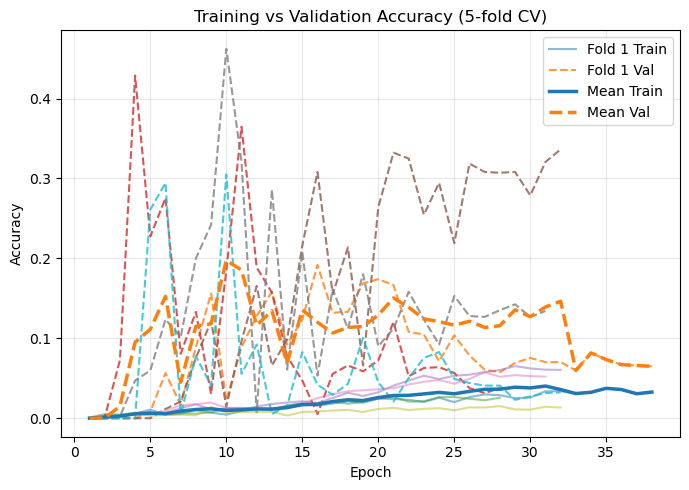

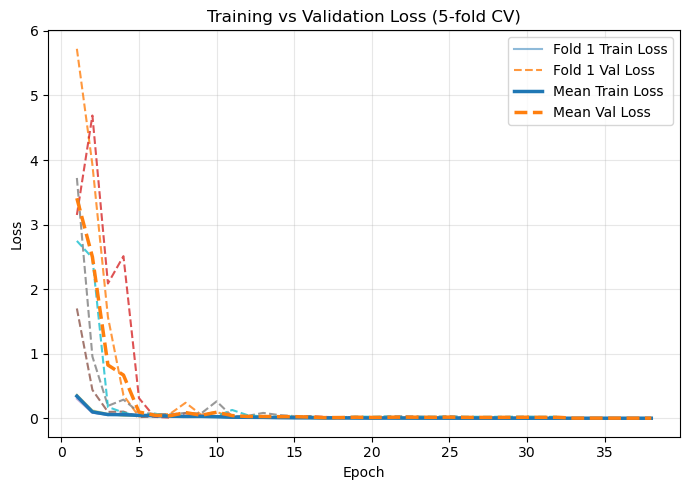

In [19]:
# ===== Step 4: Plot training/validation accuracy and loss across folds =====

def get_key(d, *candidates):
    """Return the first existing key from candidates (handles TF version differences)."""
    for k in candidates:                         # Iterate candidate keys
        if k in d:                               # If key exists in dict
            return k                             # Return it
    return None                                  # If none found, return None

# Detect metric keys (could be 'accuracy'/'acc' depending on TF/Keras version)
acc_key      = get_key(histories[0], 'accuracy', 'acc')      # Training accuracy key
val_acc_key  = get_key(histories[0], 'val_accuracy', 'val_acc')  # Validation accuracy key
loss_key     = 'loss'                                        # Training loss key
val_loss_key = 'val_loss'                                    # Validation loss key

print("History keys detected ->",
      "acc_key:", acc_key, "| val_acc_key:", val_acc_key,
      "| loss_key:", loss_key, "| val_loss_key:", val_loss_key)  # Show detected keys

# ---- Plot Accuracy ----
plt.figure(figsize=(7,5))                                     # Create figure
max_len = max(len(h[acc_key]) for h in histories)             # Longest run across folds
xs = np.arange(1, max_len+1)                                  # X-axis (epoch indices)

acc_curves, val_acc_curves = [], []                           # Lists to accumulate padded curves

for i, h in enumerate(histories, start=1):                    # For each fold history
    a  = np.array(h[acc_key], dtype=float)                    # Train acc per epoch
    va = np.array(h[val_acc_key], dtype=float)                # Val acc per epoch
    acc_curves.append(np.pad(a,  (0, max_len - len(a)),  constant_values=np.nan))   # Pad train acc
    val_acc_curves.append(np.pad(va, (0, max_len - len(va)), constant_values=np.nan))  # Pad val acc
    plt.plot(np.arange(1, len(a)+1),  a,  alpha=0.5, label=f"Fold {i} Train" if i==1 else None)   # Plot fold train
    plt.plot(np.arange(1, len(va)+1), va, alpha=0.8, linestyle='--', label=f"Fold {i} Val" if i==1 else None)  # Plot fold val

mean_acc = np.nanmean(np.vstack(acc_curves), axis=0)         # Mean train acc across folds
mean_val_acc = np.nanmean(np.vstack(val_acc_curves), axis=0) # Mean val acc across folds
plt.plot(xs, mean_acc, linewidth=2.5, label="Mean Train")     # Plot mean train
plt.plot(xs, mean_val_acc, linewidth=2.5, linestyle='--', label="Mean Val")  # Plot mean val

plt.title("Training vs Validation Accuracy (5-fold CV)")      # Title
plt.xlabel("Epoch")                                           # X label
plt.ylabel("Accuracy")                                        # Y label
plt.legend()                                                  # Legend
plt.grid(True, alpha=0.3)                                     # Grid
plt.tight_layout()                                            # Layout
plt.show()                                                    # Render

# ---- Plot Loss ----
plt.figure(figsize=(7,5))                                     # Create figure
max_len = max(len(h[loss_key]) for h in histories)            # Longest run across folds
xs = np.arange(1, max_len+1)                                  # X-axis

loss_curves, val_loss_curves = [], []                         # Lists to accumulate padded loss

for i, h in enumerate(histories, start=1):                    # For each fold history
    l  = np.array(h[loss_key], dtype=float)                   # Train loss per epoch
    vl = np.array(h[val_loss_key], dtype=float)               # Val loss per epoch
    loss_curves.append(np.pad(l,  (0, max_len - len(l)),  constant_values=np.nan))   # Pad train loss
    val_loss_curves.append(np.pad(vl, (0, max_len - len(vl)), constant_values=np.nan))  # Pad val loss
    plt.plot(np.arange(1, len(l)+1),  l,  alpha=0.5, label=f"Fold {i} Train Loss" if i==1 else None)  # Plot train
    plt.plot(np.arange(1, len(vl)+1), vl, alpha=0.8, linestyle='--', label=f"Fold {i} Val Loss" if i==1 else None)  # Plot val

mean_loss = np.nanmean(np.vstack(loss_curves), axis=0)        # Mean train loss across folds
mean_val_loss = np.nanmean(np.vstack(val_loss_curves), axis=0)# Mean val loss across folds
plt.plot(xs, mean_loss, linewidth=2.5, label="Mean Train Loss")             # Plot mean train loss
plt.plot(xs, mean_val_loss, linewidth=2.5, linestyle='--', label="Mean Val Loss")  # Plot mean val loss

plt.title("Training vs Validation Loss (5-fold CV)")          # Title
plt.xlabel("Epoch")                                           # X label
plt.ylabel("Loss")                                            # Y label
plt.legend()                                                  # Legend
plt.grid(True, alpha=0.3)                                     # Grid
plt.tight_layout()                                            # Layout
plt.show()                                                    # Render
